### Generelle Imports für die Datenaufbereitung und Erstellung von Convolutional Neural Networks

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import numpy as np
import matplotlib.pyplot as plt
import random
# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# the ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

C:\Users\mspre\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mspre\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mspre\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mspre\anaconda3\envs\tensorflow\lib\site-packages

In [2]:
import sys
from PIL import Image
sys.modules['Image'] = Image

Found 9000 images belonging to 9 classes.


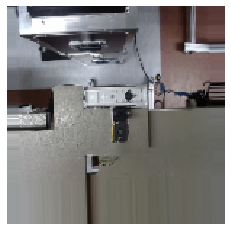

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [3]:
# These are the class names; this defines the ordering of the classes
class_names = ["Unterteil", "Knopf", "Lichtleiter", "Zwischensteg",
           "Leiterplatte", "Batterie", "Oberteil", "Schraube","Etikette"]


# Class ImageDataGenerator() returns an iterator holding one batch of images
# the constructor takes arguments defining the different image transformations
# for augmentation purposes (rotation, x-/y-shift, intensity scaling - here 1./255 
# to scale range to [0, 1], shear, zoom, flip, ... )
train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


dir_iter = train_datagen.flow_from_directory('./Daten/Rohdaten/', 
                                         target_size=(image_size, image_size),
                                         classes=class_names,
                                         batch_size=25, class_mode='sparse', shuffle=False)

plot_img(dir_iter[0][0][0,...])
dir_iter[0][1]

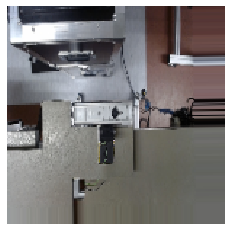

In [4]:
plot_img(dir_iter[0][0][0,...])

#### Erstes Modell definieren 

In [35]:
batch_size = 10
num_train_images = 7200
num_valid_images = 1800
num_classes = 9

model_scratch = Sequential()
model_scratch.add(Conv2D(32, (2, 2), input_shape=(image_size, image_size, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(32, (2, 2)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (2, 2)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(16, (2, 2)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(16, (2, 2)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_scratch.add(Flatten())  
model_scratch.add(Dense(32))
model_scratch.add(Activation('relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(num_classes))
model_scratch.add(Activation('softmax'))

model_scratch.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_scratch.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 149, 149, 32)      416       
_________________________________________________________________
activation_7 (Activation)    (None, 149, 149, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 73, 73, 32)        4128      
_________________________________________________________________
activation_8 (Activation)    (None, 73, 73, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 35, 35, 64)       

In [36]:
# This is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# This is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# This is a generator that will read pictures found in
# subfolers of './train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './Daten/train/',  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=class_names,
        batch_size=batch_size)  

# This is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        './Daten/validation/',
        target_size = (image_size, image_size),
        classes = class_names,
        batch_size = batch_size)

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [37]:
name = 'cnn_1_convolutional_layers_bsp2'

tensorboard = TensorBoard(
        log_dir ='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

#### Modell trainieren

In [38]:
random.seed(1234)
history = model_scratch.fit(
          train_generator,
          steps_per_epoch = num_train_images // batch_size,
          epochs = 5,
          validation_data = validation_generator,
          validation_steps = num_valid_images // batch_size,
          callbacks = [tensorboard])

Epoch 1/5
720/720 [==============================] - 485s 674ms/step - loss: 1.4081 - acc: 0.3864 - val_loss: 0.6727 - val_acc: 0.5961
Epoch 2/5
720/720 [==============================] - 469s 651ms/step - loss: 0.7346 - acc: 0.5958 - val_loss: 0.5367 - val_acc: 0.6517
Epoch 3/5
680/720 [===========================>..] - ETA: 22s - loss: 0.6524 - acc: 0.6199

KeyboardInterrupt: 

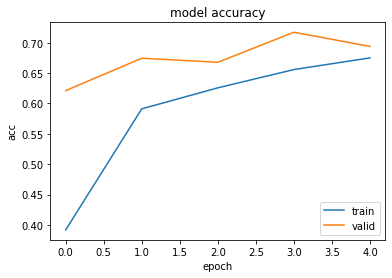

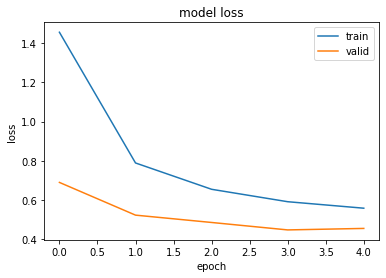

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Transfer Learning 

In [30]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

In [31]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

In [32]:
# predict_generator requires compilation
vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 1. Approach

In [34]:
# These are the class names; this defines the ordering of the classes
class_names = ["Unterteil", "Knopf", "Lichtleiter", "Zwischensteg",
           "Leiterplatte", "Batterie", "Oberteil", "Schraube","Etikette"]

# No augmentation 
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20
num_train_images = 7200
num_valid_images = 1800
num_classes = 9

generator = datagen.flow_from_directory(
        './Daten/train/',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        # this means our generator will only yield batches of 
        # data, no labels
        class_mode=None,  
        # our data will be in order
        shuffle=False)  

# the predict_generator method returns the CNN activation maps 
# of the last layer
bottleneck_features_train = vgg16.predict_generator(generator, 
                                                    num_train_images // batch_size)

print("Shape of last layer feature map of training dataset:", bottleneck_features_train.shape)

# save the output as a Numpy array
np.save('./models/1_approach/VGG16/bottleneck_features_train.npy', 
        bottleneck_features_train)

generator = datagen.flow_from_directory(
        './Daten/validation/',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = vgg16.predict_generator(generator, 
                                                         num_valid_images // batch_size)

np.save('./models/1_approach/VGG16/bottleneck_features_validation.npy', bottleneck_features_validation)

print("Shape of last layer feature map of validation dataset:", bottleneck_features_validation.shape)

Found 7200 images belonging to 9 classes.


KeyboardInterrupt: 

In [18]:
train_data = np.load('./models/1_approach/VGG16/bottleneck_features_train.npy')

# the features were saved in order, so recreating the labels is easy
train_labels = np.zeros((num_train_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_train_images // num_classes
    train_labels[ind*step:(ind+1)*step,ind]=1

train_labels.shape

(7200, 9)

In [19]:
validation_data = np.load('./models/1_approach/VGG16/bottleneck_features_validation.npy')
validation_labels = np.zeros((num_valid_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_valid_images // num_classes
    validation_labels[ind*step:(ind+1)*step,ind]=1

In [20]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
name = 'vgg16_bottleneck_face_final'

tensorboard_1 = TensorBoard(
        log_dir='./tensorboard/Transfer_Learning/1_approach/VGG16/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [22]:
history = top_model.fit(train_data, train_labels,
          epochs=20,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
          callbacks=[tensorboard_1])

top_model.save_weights('./models/1_approach/VGG16/bottleneck_fc_model.h5')

Train on 7200 samples, validate on 1800 samples
Epoch 1/20
7200/7200 [==============================] - 5s 713us/sample - loss: 0.5535 - acc: 0.7697 - val_loss: 0.3099 - val_acc: 0.8400
Epoch 2/20
7200/7200 [==============================] - 5s 651us/sample - loss: 0.2689 - acc: 0.8831 - val_loss: 0.2207 - val_acc: 0.9111
Epoch 3/20
7200/7200 [==============================] - 5s 671us/sample - loss: 0.2180 - acc: 0.9050 - val_loss: 0.2852 - val_acc: 0.8661
Epoch 4/20
7200/7200 [==============================] - 5s 645us/sample - loss: 0.1798 - acc: 0.9254 - val_loss: 0.2575 - val_acc: 0.8894
Epoch 5/20
7200/7200 [==============================] - 5s 689us/sample - loss: 0.1721 - acc: 0.9243 - val_loss: 0.1913 - val_acc: 0.9206
Epoch 6/20
7200/7200 [==============================] - 5s 740us/sample - loss: 0.1553 - acc: 0.9362 - val_loss: 0.1566 - val_acc: 0.9367
Epoch 7/20
7200/7200 [==============================] - 5s 704us/sample - loss: 0.1404 - acc: 0.9435 - val_loss: 0.1928 - va

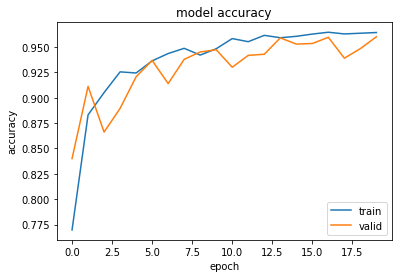

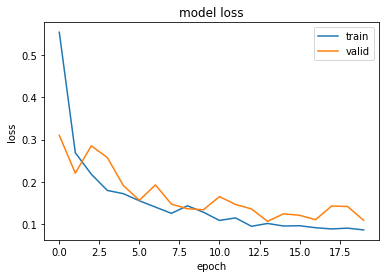

In [23]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### 2. Approach : Training the model end to end with a frozen convolutional base

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications

vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))

In [25]:
model_freeze_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 2313      
Total params: 16,814,409
Trainable params: 16,814,409
Non-trainable params: 0
_________________________________________________________________


In [26]:
print('This is the number of trainable weights '
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

vgg16.trainable = False

print('This is the number of trainable weights '
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [27]:
image_size = 150
batch_size = 20
num_train_images = 8100
num_valid_images = 900
num_classes = 9

class_names = ["Unterteil", "Knopf", "Lichtleiter", "Zwischensteg",
           "Leiterplatte", "Batterie", "Oberteil", "Schraube","Etikette"]


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './Daten/train',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        './Daten/validation',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 2313      
Total params: 16,814,409
Trainable params: 2,099,721
Non-trainable params: 14,714,688
_________________________________________________________________


In [28]:
name = 'cnn_face_2_vgg16'

tensorboard_2 = TensorBoard(
        log_dir='./tensorboard/Transfer_Learning/2_approach/VGG16/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [29]:
epochs = 10

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_2])

Epoch 1/10
405/405 [==============================] - 890s 2s/step - loss: 0.5003 - acc: 0.7931 - val_loss: 0.6246 - val_acc: 0.6956
Epoch 2/10
405/405 [==============================] - 867s 2s/step - loss: 0.2322 - acc: 0.8954 - val_loss: 0.2214 - val_acc: 0.9078
Epoch 3/10
405/405 [==============================] - 869s 2s/step - loss: 0.1869 - acc: 0.9199 - val_loss: 0.5126 - val_acc: 0.7833
Epoch 4/10
405/405 [==============================] - 930s 2s/step - loss: 0.1615 - acc: 0.9283 - val_loss: 0.2030 - val_acc: 0.9133
Epoch 5/10
405/405 [==============================] - 935s 2s/step - loss: 0.1383 - acc: 0.9421 - val_loss: 0.2757 - val_acc: 0.8822
Epoch 6/10
405/405 [==============================] - 921s 2s/step - loss: 0.1392 - acc: 0.9409 - val_loss: 0.1520 - val_acc: 0.9489
Epoch 7/10
405/405 [==============================] - 1060s 3s/step - loss: 0.1187 - acc: 0.9519 - val_loss: 0.2307 - val_acc: 0.8944
Epoch 8/10
405/405 [==============================] - 1190s 3s/step 

KeyboardInterrupt: 

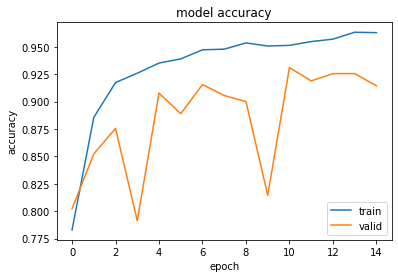

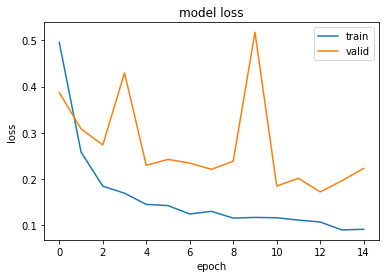

In [27]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Fine Tuning

In [2]:
vgg16.summary()

NameError: name 'vgg16' is not defined

In [29]:
vgg16.trainable = True

set_trainable = False

for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))        
    

layer name = input_2, shape = [(None, 150, 150, 3)], trainable = False
layer name = block1_conv1, shape = (None, 150, 150, 64), trainable = False
layer name = block1_conv2, shape = (None, 150, 150, 64), trainable = False
layer name = block1_pool, shape = (None, 75, 75, 64), trainable = False
layer name = block2_conv1, shape = (None, 75, 75, 128), trainable = False
layer name = block2_conv2, shape = (None, 75, 75, 128), trainable = False
layer name = block2_pool, shape = (None, 37, 37, 128), trainable = False
layer name = block3_conv1, shape = (None, 37, 37, 256), trainable = False
layer name = block3_conv2, shape = (None, 37, 37, 256), trainable = False
layer name = block3_conv3, shape = (None, 37, 37, 256), trainable = False
layer name = block3_pool, shape = (None, 18, 18, 256), trainable = False
layer name = block4_conv1, shape = (None, 18, 18, 512), trainable = False
layer name = block4_conv2, shape = (None, 18, 18, 512), trainable = False
layer name = block4_conv3, shape = (None, 1

In [30]:
model_fine_tuned = models.Sequential()
model_fine_tuned.add(vgg16)
from tensorflow.keras import optimizers

for layer in top_model.layers[0:]:
    layer.trainable = True
    model_fine_tuned.add(layer)  


model_fine_tuned.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

model_fine_tuned.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 2313      
Total params: 16,814,409
Trainable params: 9,179,145
Non-trainable params: 7,635,264
_________________________________________________________________


In [31]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './Daten/train',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        './Daten/validation',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

Found 8100 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [32]:
name = 'vgg16_face_fine_tuned_final'

tensorboard_3 = TensorBoard(
        log_dir='./tensorboard/Fine_Tuning/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [33]:
# fine-tune the model
epochs = 10

history=model_fine_tuned.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_3])

model_fine_tuned.save_weights('./models/Fine_Tuning/model_fined_tuned.h5')

Epoch 1/10
405/405 [==============================] - 1011s 2s/step - loss: 0.3892 - acc: 0.8698 - val_loss: 0.3076 - val_acc: 0.9011
Epoch 2/10
405/405 [==============================] - 1002s 2s/step - loss: 0.1813 - acc: 0.9307 - val_loss: 0.2305 - val_acc: 0.9300
Epoch 3/10
405/405 [==============================] - 1002s 2s/step - loss: 0.1413 - acc: 0.9467 - val_loss: 0.2295 - val_acc: 0.9333
Epoch 4/10
405/405 [==============================] - 1003s 2s/step - loss: 0.1098 - acc: 0.9591 - val_loss: 0.1762 - val_acc: 0.9400
Epoch 5/10
405/405 [==============================] - 1004s 2s/step - loss: 0.0968 - acc: 0.9632 - val_loss: 0.1787 - val_acc: 0.9422
Epoch 6/10
405/405 [==============================] - 1000s 2s/step - loss: 0.0836 - acc: 0.9710 - val_loss: 0.2682 - val_acc: 0.9244
Epoch 7/10
405/405 [==============================] - 1001s 2s/step - loss: 0.0813 - acc: 0.9727 - val_loss: 0.2279 - val_acc: 0.9511
Epoch 8/10
405/405 [==============================] - 1001s 2s

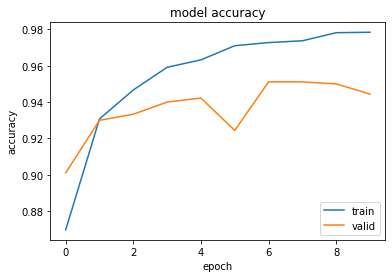

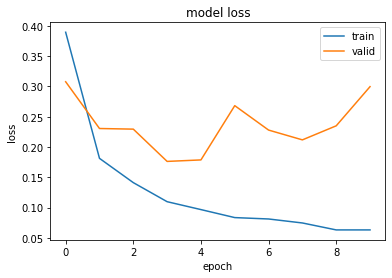

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [1]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        './Daten/validation',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_fine_tuned.predict_generator(validation_generator_no_shuffle,1)

NameError: name 'validation_datagen' is not defined

In [ ]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

In [1]:
# Choose the class label you want to check
clbl = 1
step = num_valid_images // num_classes
pred_labels = np.argmax(prediction[clbl*step:(clbl+1)*step],axis=1)
wrong_labels = np.transpose(np.nonzero(pred_labels != clbl))

print('wrong classification for: {}'.format(class_names[clbl]))
for i0 in wrong_labels:
    img = validation_generator_no_shuffle[0][0][clbl*step + i0,...]
    plot_img(img.reshape(150,150,3))
    print('matched to: {}'.format(class_names[pred_labels[i0][0]]))
    

NameError: name 'num_valid_images' is not defined

## Visualisieren was CNN lernen 

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [11]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2
# Local path to the target image
img_path = 'C:\\Users\\mspre\\Desktop\\Data Science\\4.Semester\\Masterthesis\\gelber_knopf.jpg'
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(224,224))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

(1080, 1920, 3)
(1, 224, 224, 3)


In [12]:
preds = model.predict(x)
print('Predicted', decode_predictions(preds, top=3)[0])

Predicted [('n03297495', 'espresso_maker', 0.09546729), ('n04009552', 'projector', 0.08174145), ('n03532672', 'hook', 0.0683959)]


In [13]:
np.argmax(preds[0])

550

## GRAD-Cam Algorithmus

In [14]:
# import the necessary packages

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# from tensorflow.keras.applications import imagenet_utils
from keras.applications import imagenet_utils
import numpy as np
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)


# initialize the model to be VGG16
Model = VGG16

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")



# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
# !pip install opencv-python-headless
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")  

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) 
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        #(w, h) = (image.shape[2], image.shape[1])
        heatmap = cam.numpy()
        #heatmap = cv2.resize(cam_num, (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

 

index_true_class = np.argmax(preds[0])
print(index_true_class)
cam = GradCAM(model, index_true_class)
heatmap = cam.compute_heatmap(x)
print(heatmap.shape)

[INFO] loading model...


ValueError: You are trying to load a weight file containing 3 layers into a model with 16 layers.

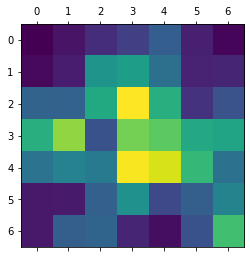

In [8]:
plt.matshow(heatmap)

In [9]:
import cv2

# uses cv2 to load the original image
img = cv2.imread(img_path) 

# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# saves the image to disk
cv2.imwrite('./gelber_knopf_cam.jpg', superimposed_img)

True